In [51]:
import numpy as np
import torch.nn as nn
import copy

def get_data(x_range, y_range, x_num, y_num):
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)

    x_mesh, t_mesh = np.meshgrid(x,t)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)

    b_left = data[0,:,:]
    b_right = data[-1,:,:]
    b_upper = data[:,-1,:]
    b_lower = data[:,0,:]
    res = data.reshape(-1,2)

    return res, b_left, b_right, b_upper, b_lower


def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp


def make_time_sequence(src, num_step=5, step=1e-4):
    dim = num_step
    src = np.repeat(np.expand_dims(src, axis=1), dim, axis=1)  # (N, L, 2)
    for i in range(num_step):
        src[:,i,-1] += step*i
    return src


def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


def get_data_3d(x_range, y_range, t_range, x_num, y_num, t_num):
    step_x = (x_range[1] - x_range[0]) / float(x_num-1)
    step_y = (y_range[1] - y_range[0]) / float(y_num-1)
    step_t = (t_range[1] - t_range[0]) / float(t_num-1)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[0]:x_range[1]+step_x:step_x,y_range[0]:y_range[1]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]

    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    res = data.reshape(-1,3)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[0]:x_range[0]+step_x:step_x,y_range[0]:y_range[1]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]
    b_left = np.squeeze(np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1))[1:-1].reshape(-1,3)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[1]:x_range[1]+step_x:step_x,y_range[0]:y_range[1]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]
    b_right = np.squeeze(np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1))[1:-1].reshape(-1,3)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[0]:x_range[1]+step_x:step_x,y_range[0]:y_range[0]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]
    b_lower = np.squeeze(np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1))[1:-1].reshape(-1,3)

    x_mesh, y_mesh, t_mesh = np.mgrid[x_range[0]:x_range[1]+step_x:step_x,y_range[1]:y_range[1]+step_y:step_y,t_range[0]:t_range[1]+step_t:step_t]
    b_upper = np.squeeze(np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(y_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1))[1:-1].reshape(-1,3)

    return res, b_left, b_right, b_upper, b_lower

In [53]:
### ADJUSTED for transfer learning experiments!!! additional input for equation parameter added ###

# implementation of PINNsformer
# paper: PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks
# link: https://arxiv.org/abs/2307.11833

import torch
import torch.nn as nn
import pdb



class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__()
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__()
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x):
        x2 = self.act1(x)
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x, e_outputs):
        x2 = self.act1(x)
        x = x + self.attn(x2, e_outputs, e_outputs)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Encoder, self).__init__()
        self.N = N
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.act = WaveAct()

    def forward(self, x):
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x)


class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.act = WaveAct()

    def forward(self, x, e_outputs):
        for i in range(self.N):
            x = self.layers[i](x, e_outputs)
        return self.act(x)


class PINNsformer_params(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads):
        """
        Adapted PINNsformer that takes three inputs: x, t, and rho.
        Args:
            d_out (int): Output dimension.
            d_model (int): Dimension of the model embeddings.
            d_hidden (int): Hidden layer dimension in the output MLP.
            N (int): Number of encoder/decoder layers.
            heads (int): Number of attention heads.
        """
        super(PINNsformer_params, self).__init__()
        # Change input dimension from 2 to 3 to accommodate x, t, and rho
        self.linear_emb = nn.Linear(3, d_model)

        self.encoder = Encoder(d_model, N, heads)
        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        )

    def forward(self, x, t, rho):
        # Concatenate x, t, and rho along the last dimension
        src = torch.cat((x, t, rho), dim=-1)
        src = self.linear_emb(src)

        e_outputs = self.encoder(src)
        d_output = self.decoder(src, e_outputs)
        output = self.linear_out(d_output)
        return output

In [54]:
import torch
import os
import sys
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm
import wandb
from pathlib import Path

# make sure that util is correctly accessed from parent directory
ppp_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if ppp_dir not in sys.path:
    sys.path.insert(0, ppp_dir)



In [55]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If CUDA is available, print the CUDA version
if cuda_available:
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

CUDA available: True
CUDA version: 12.4
Number of CUDA devices: 1
Current CUDA device: 0
CUDA device name: Tesla T4


In [56]:
# set seeds and configure cuda device
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:0'

In [57]:
class PDEData(Dataset):
    def __init__(self, x_range, t_range, rho_values, x_points, t_points):
        """
        Initialize the dataset for PDE data with multiple rho values.

        Args:
            x_range (list): Spatial domain [x_min, x_max].
            t_range (list): Temporal domain [t_min, t_max].
            rho_values (list): List of rho values for different scenarios.
            x_points (int): Number of points in the spatial domain.
            t_points (int): Number of points in the temporal domain.
            device (str): Device to store the tensors ('cpu' or 'cuda').
        """
        self.device = "cuda:0"
        self.x_range = x_range
        self.t_range = t_range
        self.rho_values = rho_values  # Store multiple rho values
        self.x_points = x_points
        self.t_points = t_points

        # Generate the data for all rho values
        self.data = {}
        for rho in rho_values:
            res, b_left, b_right, b_upper, b_lower = self._generate_data()

            # Convert boundary points to PyTorch tensors
            b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(self.device)
            b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(self.device)
            b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(self.device)
            b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(self.device)

            self.data[rho] = {
                'res': torch.tensor(res, dtype=torch.float32, requires_grad=True).to(self.device),
                'b_left': b_left,
                'b_right': b_right,
                'b_upper': b_upper,
                'b_lower': b_lower,
                # Precompute analytical solutions for boundary points
                'u_left': self.analytical_solution(b_left[:, 0:1], b_left[:, 1:2], rho),
                'u_right': self.analytical_solution(b_right[:, 0:1], b_right[:, 1:2], rho),
                'u_upper': self.analytical_solution(b_upper[:, 0:1], b_upper[:, 1:2], rho),
                'u_lower': self.analytical_solution(b_lower[:, 0:1], b_lower[:, 1:2], rho),
            }

    def _generate_data(self):
        """
        Generate the interior and boundary points for the PDE.

        Returns:
            res (np.ndarray): Interior points.
            b_left, b_right, b_upper, b_lower (np.ndarray): Boundary points.
        """
        x = np.linspace(self.x_range[0], self.x_range[1], self.x_points)
        t = np.linspace(self.t_range[0], self.t_range[1], self.t_points)

        x_mesh, t_mesh = np.meshgrid(x, t)
        data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)

        b_left = data[0, :, :]
        b_right = data[-1, :, :]
        b_upper = data[:, -1, :]
        b_lower = data[:, 0, :]
        res = data.reshape(-1, 2)

        return res, b_left, b_right, b_upper, b_lower

    def analytical_solution(self, x, t, rho):
        """
        Compute the analytical solution u_ana(x, t, rho).

        Args:
            x (torch.Tensor): Spatial points.
            t (torch.Tensor): Temporal points.
            rho (float): Reaction coefficient.

        Returns:
            torch.Tensor: Analytical solution u(x, t, rho).
        """
        h = torch.exp(- (x - torch.pi)**2 / (2 * (torch.pi / 4)**2))
        return h * torch.exp(rho * t) / (h * torch.exp(rho * t) + 1 - h)

    def get_interior_points(self, rho):
        """
        Get the interior points (x_res, t_res, rho_res) for a specific rho.

        Args:
            rho (float): The rho value for the current scenario.

        Returns:
            x_res, t_res, rho_res (torch.Tensor): Interior points with rho values.
        """
        res = self.data[rho]['res']
        x_res, t_res = res[:, 0:1], res[:, 1:2]
        rho_res = torch.full_like(x_res, rho)  # Same shape, constant rho
        return x_res, t_res, rho_res

    def get_boundary_points(self, rho):
        """
        Get the boundary points (x_left, t_left, etc.) for a specific rho.

        Args:
            rho (float): The rho value for the current scenario.

        Returns:
            Boundary points (torch.Tensor): x, t, and rho values for all boundaries.
        """
        b_left = self.data[rho]['b_left']
        b_right = self.data[rho]['b_right']
        b_upper = self.data[rho]['b_upper']
        b_lower = self.data[rho]['b_lower']

        x_left, t_left = b_left[:, 0:1], b_left[:, 1:2]
        x_right, t_right = b_right[:, 0:1], b_right[:, 1:2]
        x_upper, t_upper = b_upper[:, 0:1], b_upper[:, 1:2]
        x_lower, t_lower = b_lower[:, 0:1], b_lower[:, 1:2]

        rho_left = torch.full_like(x_left, rho)
        rho_right = torch.full_like(x_right, rho)
        rho_upper = torch.full_like(x_upper, rho)
        rho_lower = torch.full_like(x_lower, rho)

        return x_left, t_left, rho_left, x_right, t_right, rho_right, x_upper, t_upper, rho_upper, x_lower, t_lower, rho_lower

    def get_boundary_values(self, rho):
        """
        Get the precomputed analytical solutions for the boundary points.

        Args:
            rho (float): The rho value for the current scenario.

        Returns:
            u_left, u_right, u_upper, u_lower (torch.Tensor): Analytical solutions at the boundaries.
        """
        return (self.data[rho]['u_left'], self.data[rho]['u_right'],
                self.data[rho]['u_upper'], self.data[rho]['u_lower'])

    def get_test_points(self, rho):
        """
        Get the test points (res_test) and their spatial and temporal components for a specific rho.

        Args:
            rho (float): The rho value for the current scenario.

        Returns:
            res_test (torch.Tensor): Test points as a tensor.
            x_test, t_test, rho_test (torch.Tensor): Spatial, temporal, and rho components of the test points.
        """
        res_test = self.data[rho]['res']
        x_test, t_test = res_test[:, 0:1], res_test[:, 1:2]
        rho_test = torch.full_like(x_test, rho)  # Same shape, constant rho
        return res_test, x_test, t_test, rho_test

In [59]:
# %%
# Configuration parameters and wandb logging
total_i = 5
model_name = "pinnsformer_params"
config_dict = {
    "total_i": total_i,
    "model": model_name,
    "d_out": 1,
    "d_model": 32,
    "d_hidden": 512,
    "N": 1,
    "heads": 2,
    "bias_fill": 0.01,
    "optimizer": "adam",
    "batch_size": 128,
    "learning_rate": 1e-3
}

run = wandb.init(
    project="pinnsformer",
    config=config_dict,
    settings=wandb.Settings(silent=True)
)

# %%
# Weight initialization function
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(config_dict["bias_fill"])

In [60]:
model = PINNsformer_params(
    d_out=config_dict["d_out"],
    d_model=config_dict["d_model"],
    d_hidden=config_dict["d_hidden"],
    N=config_dict["N"],
    heads=config_dict["heads"]
).to(device)

model.apply(init_weights)
if config_dict["optimizer"] == "LBFGS":
    optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
elif config_dict["optimizer"] == "adam":
    optim = Adam(model.parameters(), lr=config_dict["learning_rate"])

print(model)
print(get_n_params(model))

PINNsformer_params(
  (linear_emb): Linear(in_features=3, out_features=32, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear):

In [61]:
rho_values = [2.0,5.0,10.0,20.0]
dataset = PDEData(x_range=[0, 2 * np.pi], t_range=[0, 1], rho_values=rho_values, x_points=101, t_points=101)
total_i = config_dict["total_i"]
loss_track = {i: {} for i in range(total_i)}

In [63]:
if config_dict["optimizer"] == "LBFGS":
    for i in tqdm(range(total_i)):
        for rho in rho_values:
            def closure():
                # Get interior points
                x_res, t_res, rho_res = dataset.get_interior_points(rho)
                # Get boundary points and their analytical values
                x_left, t_left, rho_left, x_right, t_right, rho_right, x_upper, t_upper, rho_upper, x_lower, t_lower, rho_lower = dataset.get_boundary_points(rho)
                u_left, u_right, u_upper, u_lower = dataset.get_boundary_values(rho)

                # Model predictions for interior and boundary points
                pred_res = model(x_res, t_res, rho_res)
                pred_left = model(x_left, t_left, rho_left)
                pred_right = model(x_right, t_right, rho_right)
                pred_upper = model(x_upper, t_upper, rho_upper)
                pred_lower = model(x_lower, t_lower, rho_lower)

                # Compute derivatives with respect to space and time
                u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res),
                                            retain_graph=True, create_graph=True)[0]
                u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res),
                                            retain_graph=True, create_graph=True)[0]

                # Define the loss terms:
                # PDE residual loss (here we assume u_t - rho * u * (1-u) = 0, adjust as needed)
                loss_res = torch.mean((u_t - rho * pred_res * (1 - pred_res)) ** 2)
                # Boundary condition loss (e.g., matching the solution at t=t_min vs t=t_max)
                loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
                # Initial condition loss (here comparing the left boundary with the analytical solution)
                loss_ic = torch.mean((pred_left[:,0] - u_left[:,0]) ** 2)

                loss = loss_res + loss_bc + loss_ic

                wandb.log({
                    "loss": loss.item(),
                    "loss_res": loss_res.item(),
                    "loss_bc": loss_bc.item(),
                    "loss_ic": loss_ic.item(),
                    "iteration": i,
                    "rho": rho
                })

                # Track losses in a dictionary
                if rho not in loss_track[i]:
                    loss_track[i][rho] = {}
                loss_track[i][rho]["loss_res"] = loss_res.item()
                loss_track[i][rho]["loss_bc"] = loss_bc.item()
                loss_track[i][rho]["loss_ic"] = loss_ic.item()

                optim.zero_grad()
                loss.backward(retain_graph=True)
                return loss

            optim.step(closure)

    wandb.finish()

In [64]:
# Define rho values
rho_values = [2.0,5.0,10.0,20.0]
total_i = config_dict["total_i"]

# Create the dataset
dataset = PDEData(x_range=[0, 2 * torch.pi], t_range=[0, 1], rho_values=rho_values, x_points=101, t_points=101)

# Training loop
loss_track = {i: {} for i in range(total_i)}  # Initialize a dictionary for tracking losses

for i in tqdm(range(total_i)):
    total_loss_res = 0.0
    total_loss_bc = 0.0
    total_loss_ic = 0.0
    num_batches = 0  # Track the number of batches

    for rho in rho_values:
        # Get interior points and create a mini-batch DataLoader
        x_res, t_res, rho_res = dataset.get_interior_points(rho)
        interior_dataset = TensorDataset(x_res, t_res, rho_res)
        interior_loader = DataLoader(interior_dataset, batch_size=config_dict["batch_size"], shuffle=True)

        # Get full boundary data for current rho
        (x_left, t_left, rho_left,
         x_right, t_right, rho_right,
         x_upper, t_upper, rho_upper,
         x_lower, t_lower, rho_lower) = dataset.get_boundary_points(rho)
        u_left, u_right, u_upper, u_lower = dataset.get_boundary_values(rho)

        for bx, bt, brho in interior_loader:
            # Ensure mini-batch inputs require gradients for differentiation
            bx.requires_grad_()
            bt.requires_grad_()

            # Forward pass on interior mini-batch
            pred_res = model(bx, bt, brho)
            # Compute derivative with respect to time
            u_t = torch.autograd.grad(pred_res, bt,
                                       grad_outputs=torch.ones_like(pred_res),
                                       retain_graph=True,
                                       create_graph=True)[0]

            # Compute residual loss
            loss_res = torch.mean((u_t - rho * pred_res * (1 - pred_res)) ** 2)

            # Forward pass on full-boundary data
            pred_left  = model(x_left, t_left, rho_left)
            pred_right = model(x_right, t_right, rho_right)
            pred_upper = model(x_upper, t_upper, rho_upper)
            pred_lower = model(x_lower, t_lower, rho_lower)

            # Compute boundary condition loss
            loss_bc = torch.mean((pred_upper - pred_lower) ** 2) + \
                      torch.mean((pred_left - u_left) ** 2) + \
                      torch.mean((pred_right - u_right) ** 2)

            # Compute initial condition loss
            loss_ic = torch.mean((pred_lower - u_lower) ** 2)

            # Total loss
            loss = loss_res + loss_bc + loss_ic

            # Accumulate losses for averaging
            total_loss_res += loss_res.item()
            total_loss_bc += loss_bc.item()
            total_loss_ic += loss_ic.item()
            num_batches += 1

            # Backward pass and optimization step
            optim.zero_grad()
            loss.backward(retain_graph=True)
            optim.step()

        # Compute average losses
        avg_loss_res = total_loss_res / num_batches
        avg_loss_bc = total_loss_bc / num_batches
        avg_loss_ic = total_loss_ic / num_batches
        avg_total_loss = avg_loss_res + avg_loss_bc + avg_loss_ic

        # Log average losses at the end of the iteration
        wandb.log({
            "iteration": i,
            "avg_loss_res": avg_loss_res,
            "avg_loss_bc": avg_loss_bc,
            "avg_loss_ic": avg_loss_ic,
            "avg_total_loss": avg_total_loss
        })

        # Track average losses in a dictionary
        loss_track[i][rho] = {
            "loss_res": avg_loss_res,
            "loss_bc": avg_loss_bc,
            "loss_ic": avg_loss_ic
        }

wandb.finish()


100%|██████████| 5/5 [01:40<00:00, 20.02s/it]


In [65]:
base_dir = Path(".")
images_dir = base_dir / "images"
weights_dir = base_dir / "weights"
images_dir.mkdir(parents=True, exist_ok=True)
weights_dir.mkdir(parents=True, exist_ok=True)

In [66]:
# Print final losses for each rho value
last_iteration = total_i - 1
for rho in rho_values:
    print('Rho: {:4f}, Loss Res: {:4f}, Loss BC: {:4f}, Loss IC: {:4f}'.format(
        rho,
        loss_track[last_iteration][rho]["loss_res"],
        loss_track[last_iteration][rho]["loss_bc"],
        loss_track[last_iteration][rho]["loss_ic"]
    ))
    total_loss = (loss_track[last_iteration][rho]["loss_res"] +
                  loss_track[last_iteration][rho]["loss_bc"] +
                  loss_track[last_iteration][rho]["loss_ic"])
    print('Train Loss: {:4f}'.format(total_loss))

model_path = weights_dir / "1d_reaction_pinnsformer_extended.pt"
torch.save(model.state_dict(), model_path)

Rho: 2.000000, Loss Res: 0.005242, Loss BC: 0.355354, Loss IC: 0.004822
Train Loss: 0.365418
Rho: 5.000000, Loss Res: 0.178480, Loss BC: 0.517449, Loss IC: 0.050285
Train Loss: 0.746214
Rho: 10.000000, Loss Res: 0.281608, Loss BC: 0.712675, Loss IC: 0.071909
Train Loss: 1.066192
Rho: 20.000000, Loss Res: 0.256726, Loss BC: 0.698443, Loss IC: 0.180674
Train Loss: 1.135842


In [67]:
# Evaluation
errors = []
for rho in rho_values:
    res_test, x_test, t_test, rho_test = dataset.get_test_points(rho)
    u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(101, 101)

    with torch.no_grad():
        pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
        pred = pred.cpu().detach().numpy().reshape(101, 101)

    rl1 = np.sum(np.abs(u_analytical - pred)) / np.sum(np.abs(u_analytical))
    rl2 = np.sqrt(np.sum((u_analytical - pred)**2) / np.sum(u_analytical**2))
    print(f"Rho: {rho}, Relative L1 error: {rl1:.4f}, Relative L2 error: {rl2:.4f}")
    errors.append((rho, rl1, rl2))


Rho: 2.0, Relative L1 error: 0.8391, Relative L2 error: 0.7843
Rho: 5.0, Relative L1 error: 0.9417, Relative L2 error: 0.9073
Rho: 10.0, Relative L1 error: 0.9771, Relative L2 error: 0.9728
Rho: 20.0, Relative L1 error: 0.1715, Relative L2 error: 0.3626


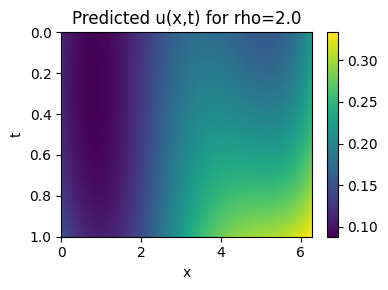

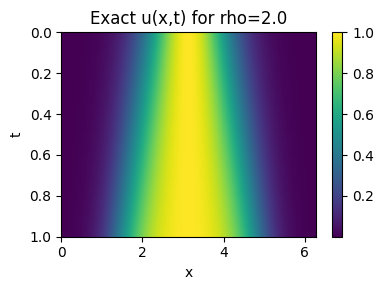

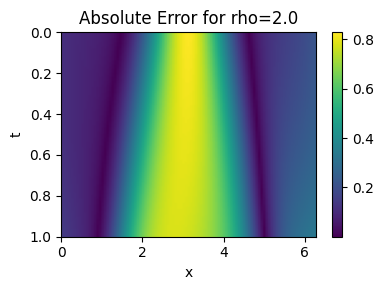

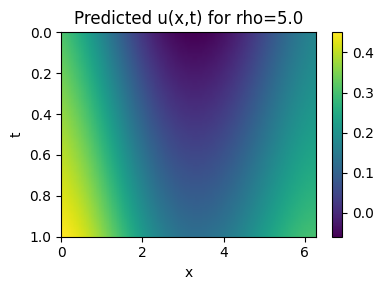

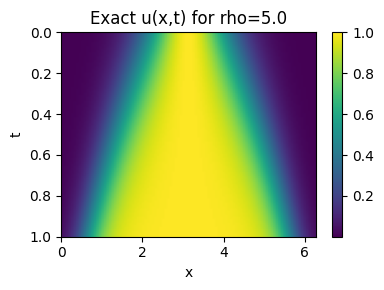

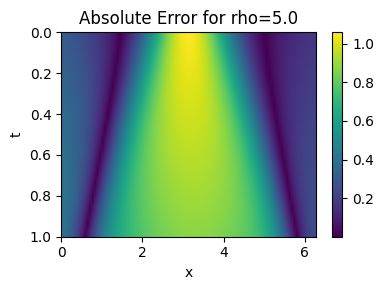

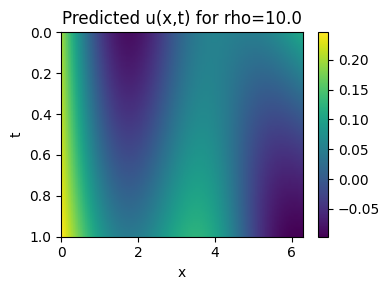

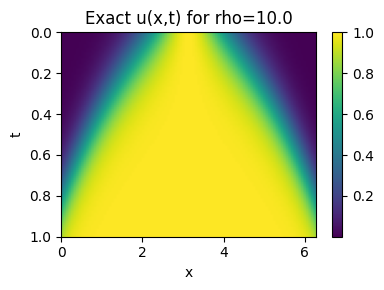

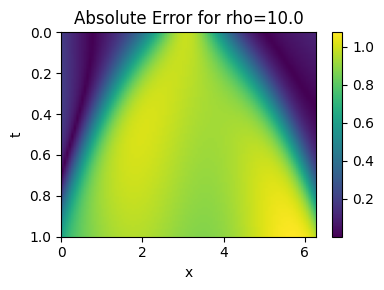

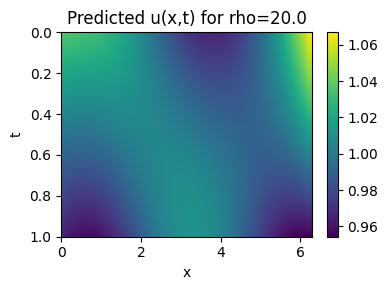

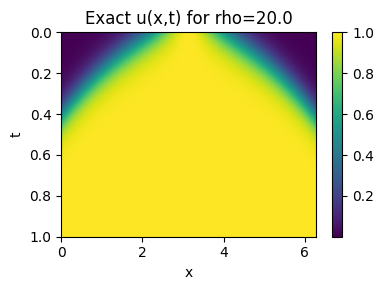

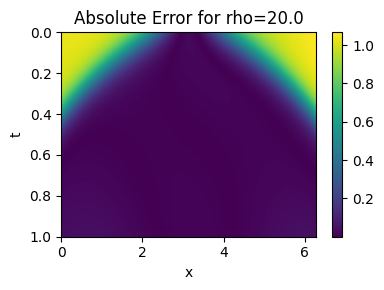

In [68]:
# %%
# Visualization
for rho in rho_values:
    res_test, x_test, t_test, rho_test = dataset.get_test_points(rho)
    u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(101, 101)
    with torch.no_grad():
        pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
        pred = pred.cpu().detach().numpy().reshape(101, 101)
    abs_error = np.abs(u_analytical - pred)

    # Plot predicted solution
    plt.figure(figsize=(4, 3))
    plt.imshow(pred, extent=[0, 2 * np.pi, 1, 0], aspect='auto')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(f'Predicted u(x,t) for rho={rho}')
    plt.colorbar()
    plt.tight_layout()
    plot_path = images_dir / f"1d_reaction_pinnsformer_pred_rho-{rho}.png"
    plt.savefig(plot_path)
    plt.show()

    # Plot analytical solution
    plt.figure(figsize=(4, 3))
    plt.imshow(u_analytical, extent=[0, 2 * np.pi, 1, 0], aspect='auto')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(f'Exact u(x,t) for rho={rho}')
    plt.colorbar()
    plt.tight_layout()
    plot_path = images_dir / f"1d_reaction_pinnsformer_exact_rho-{rho}.png"
    plt.savefig(plot_path)
    plt.show()

    # Plot absolute error
    plt.figure(figsize=(4, 3))
    plt.imshow(abs_error, extent=[0, 2 * np.pi, 1, 0], aspect='auto')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(f'Absolute Error for rho={rho}')
    plt.colorbar()
    plt.tight_layout()
    plot_path = images_dir / f"1d_reaction_pinnsformer_error_rho-{rho}.png"
    plt.savefig(plot_path)
    plt.show()

In [69]:
# Define the new rho value for inference
rho_values = [50.0]
rho_inference = 50.0

dataset = PDEData(x_range=[0, 2 * np.pi], t_range=[0, 1], rho_values=rho_values, x_points=101, t_points=101)


# Get test points for the new rho value
res_test, x_test, t_test, rho_test = dataset.get_test_points(50.0)
u_analytical = dataset.analytical_solution(x_test, t_test, 50).cpu().detach().numpy().reshape(101, 101)

# Perform inference
with torch.no_grad():
    pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
    pred = pred.cpu().detach().numpy().reshape(101, 101)

# Compute accuracy metrics
rl1 = np.sum(np.abs(u_analytical - pred)) / np.sum(np.abs(u_analytical))
rl2 = np.sqrt(np.sum((u_analytical - pred)**2) / np.sum(u_analytical**2))
print(f"Rho: {rho_inference}, Relative L1 error: {rl1:.4f}, Relative L2 error: {rl2:.4f}")



Rho: 50.0, Relative L1 error: 0.8160, Relative L2 error: 0.8184


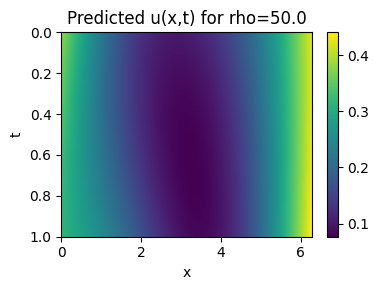

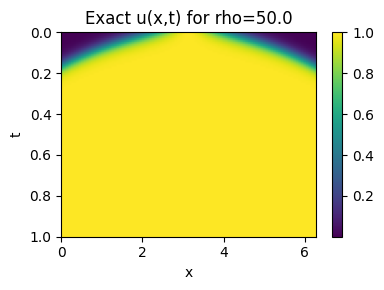

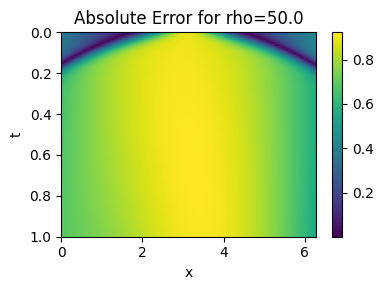

In [71]:
# Visualization for rho=50
rho_values = [50.0]
rho_inference = 50.0

dataset = PDEData(x_range=[0, 2 * np.pi], t_range=[0, 1], rho_values=rho_values, x_points=101, t_points=101)

# Get test points for the new rho value
res_test, x_test, t_test, rho_test = dataset.get_test_points(rho_inference)
u_analytical = dataset.analytical_solution(x_test, t_test, rho_inference).cpu().detach().numpy().reshape(101, 101)
abs_error = np.abs(u_analytical - pred)


# Plot predicted solution
plt.figure(figsize=(4, 3))
plt.imshow(pred, extent=[0, 2 * np.pi, 1, 0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'Predicted u(x,t) for rho={rho_inference}')
plt.colorbar()
plt.tight_layout()
plot_path = images_dir / f"1d_reaction_pinnsformer_pred_rho-{rho_inference}.png"
plt.savefig(plot_path)
plt.show()

# Plot analytical solution
plt.figure(figsize=(4, 3))
plt.imshow(u_analytical, extent=[0, 2 * np.pi, 1, 0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'Exact u(x,t) for rho={rho_inference}')
plt.colorbar()
plt.tight_layout()
plot_path = images_dir / f"1d_reaction_pinnsformer_exact_rho-{rho_inference}.png"
plt.savefig(plot_path)
plt.show()

# Plot absolute error
plt.figure(figsize=(4, 3))
plt.imshow(abs_error, extent=[0, 2 * np.pi, 1, 0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'Absolute Error for rho={rho_inference}')
plt.colorbar()
plt.tight_layout()
plot_path = images_dir / f"1d_reaction_pinnsformer_error_rho-{rho_inference}.png"
plt.savefig(plot_path)
plt.show()